<a href="https://colab.research.google.com/github/asarvi/RBM_BM/blob/main/BM_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import torch

In the first part, we load the MNIST dataset.
According to the data provided in the report, I chose the number 50 for batch size.

In [45]:
import torchvision
from torch.utils.data import DataLoader, Subset

#init batch size
batch_size = 50

#define transform
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

#load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',train=True,
                download=True,transform=transform
)

# define validation set and split dataset
validation_split = 0.1
validation_size = int(0.1 * len(train_dataset))
train_size = len(train_dataset) - validation_size
train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset,
                                    [train_size, validation_size])

# create data loaders for training, validation, and test sets
train_loader = DataLoader(train_dataset,batch_size,shuffle=True)
test_dataset = torchvision.datasets.MNIST( root='./data',train=False,
    download=True,
    transform=transform
)
test_loader = DataLoader(test_dataset,batch_size,shuffle=False)
validation_loader = DataLoader(validation_dataset,batch_size,shuffle=False)



In [3]:
import torch.nn as nn
#definition of sigmoid function
def sigmoid ( x ):
   sig = 1 / (1 + torch.exp(-x))
   return sig
#definition of relu function
def relu(x):
    r = torch.relu(x)
    return r

The Class FCBM, which is a fully connected Boltzmann Machine is defined here.




Training loss for 0 epoch: -8.2853
Validation loss for 0 epoch: -6.5179
Training loss for 1 epoch: -5.3780
Validation loss for 1 epoch: -4.1446
Training loss for 2 epoch: -3.3993
Validation loss for 2 epoch: -2.2402
Training loss for 3 epoch: -2.2539
Validation loss for 3 epoch: -1.2377
Training loss for 4 epoch: -1.3910
Validation loss for 4 epoch: -0.7030
Training loss for 5 epoch: -0.9592
Validation loss for 5 epoch: -0.0351
Training loss for 6 epoch: -0.6074
Validation loss for 6 epoch: 0.1262
Training loss for 7 epoch: -0.3384
Validation loss for 7 epoch: 0.1636
Training loss for 8 epoch: -0.1461
Validation loss for 8 epoch: 0.2893
Training loss for 9 epoch: 0.0131
Validation loss for 9 epoch: 0.3402


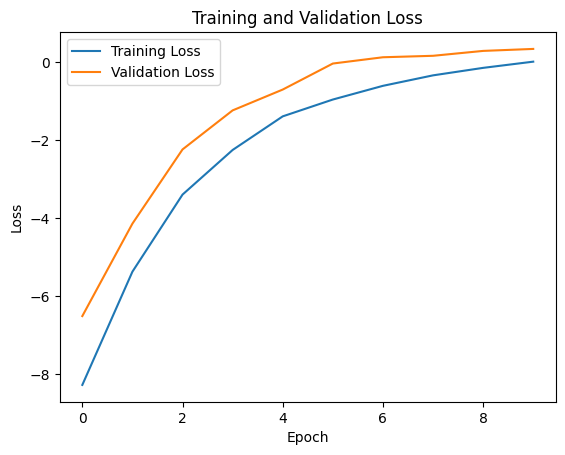

Total time is: 274.87913727760315 seconds


In [47]:
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

# init model parameters,
#number of visible units is the input size, which is 28 * 28
#I picked 612 for hidden units according to one of the methods in the report
class FCBM(nn.Module):
    def __init__(self, num_vis_units=784, num_hid_units=612, num_CD=5):
        super(FCBM, self).__init__()
        xscale = math.sqrt(2.0 / (num_hid_units + num_vis_units))
        self.Weights = nn.Parameter(torch.randn(num_hid_units, num_vis_units) * xscale)
        self.num_CD = num_CD
        self.vbias = nn.Parameter(torch.zeros(num_vis_units))
        self.hbias = nn.Parameter(torch.zeros(num_hid_units))


    def sample_BM(self, p):
        init_probs = torch.rand(p.size())
        samples = (p >= init_probs).float()
        return samples

    def forward(self, v):
        hid_prob = sigmoid(torch.matmul(v, self.Weights.t()) + self.hbias)
        hid_sample = self.sample_BM(hid_prob)

        for _ in range(self.num_CD):
            vis_prob = sigmoid(torch.matmul(hid_sample, self.Weights) + self.vbias)
            vis_sample = self.sample_BM(vis_prob)

            hid_prob = sigmoid(torch.matmul(vis_sample, self.Weights.t()) + self.hbias)
            hid_sample = self.sample_BM(hid_prob)

        return v, vis_sample


    def free_energy(self, v):

        vbias = torch.mv(v, self.vbias)
        weights = torch.mm(v, self.Weights.t()) + self.hbias.unsqueeze(0).expand_as(torch.mm(v, self.Weights.t()))
        hidden_term = weights.exp().add(1).log().sum(1)
        total_free_energy = - vbias -hidden_term
        mean_free_energy = total_free_energy.mean()

        return mean_free_energy

rbm = FCBM(num_CD=1)
epochs = 10
train_losses = []
val_losses = []
train_op = optim.SGD(rbm.parameters(), lr=0.08)
time_begin = time.time()
for epoch in range(epochs):
    # training
    print("Training loss for {} epoch: ".format(epoch), end='')
    total_train_loss = 0.0
    num_train_batches = len(train_loader)
    for batch_idx, (data, target) in enumerate(train_loader):
        data = Variable(data.view(-1, 784))
        sample_data = data.bernoulli()

        # forward pass
        v, v1 = rbm(sample_data)
        # calculate loss
        loss = rbm.free_energy(v) - rbm.free_energy(v1)
        total_train_loss += loss.item()
        # backward pass and optimization
        train_op.zero_grad()
        loss.backward()
        train_op.step()
        # display batch loss
        if batch_idx == num_train_batches - 1:
            batch_train_loss = total_train_loss / num_train_batches
            print("{:.4f}".format(batch_train_loss))
            train_losses.append(batch_train_loss)

    # Validation
    print("Validation loss for {} epoch: ".format(epoch), end='')
    total_val_loss = 0.0
    num_val_batches = len(validation_loader)
    with torch.no_grad():
        for data, target in validation_loader:
            data = Variable(data.view(-1, 784))
            sample_data = data.bernoulli()
            # forward pass
            v, v1 = rbm(sample_data)
            # calculate loss
            loss = rbm.free_energy(v) - rbm.free_energy(v1)
            total_val_loss += loss.item()
    time_end = time.time()
    batch_val_loss = total_val_loss / num_val_batches
    print("{:.4f}".format(batch_val_loss))
    val_losses.append(batch_val_loss)


plt.plot(range(0, epochs), train_losses,linestyle='-', label='Training Loss')
plt.plot(range(0, epochs), val_losses, linestyle='-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
total_training_time = time_end - time_begin
print("Total time is:", total_training_time, "seconds")


Here you can see a few examples: in each iteration a training sample (number) and a generated sample are shown.

Training Sample: 


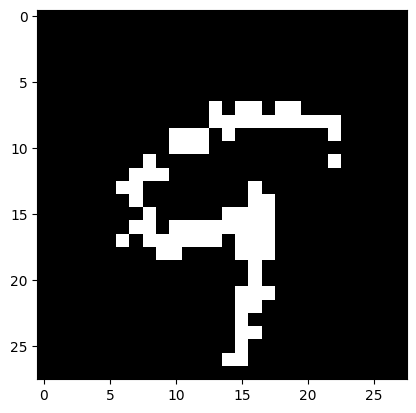

Generated Sample: 


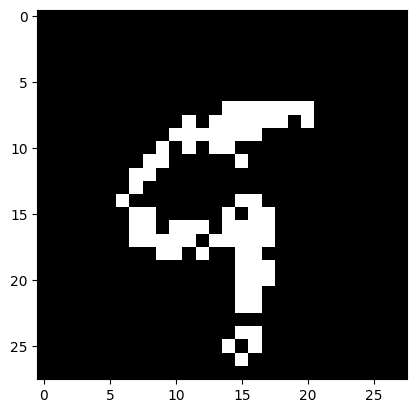

Training Sample: 


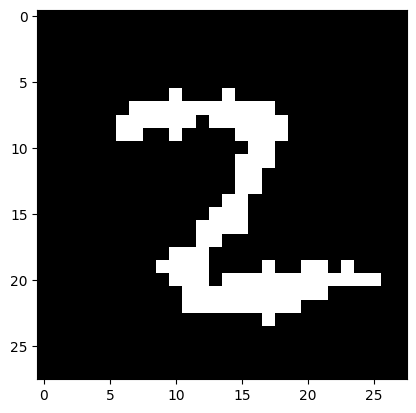

Generated Sample: 


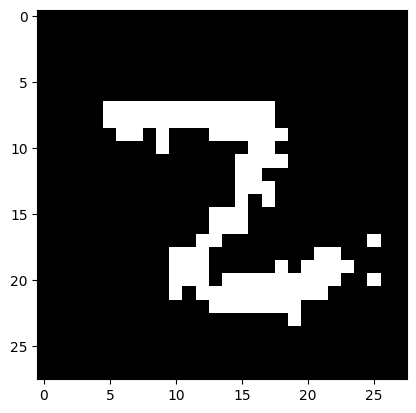

Training Sample: 


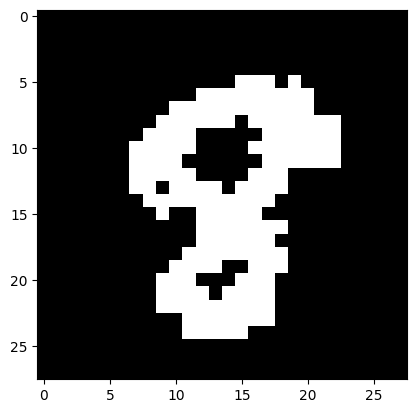

Generated Sample: 


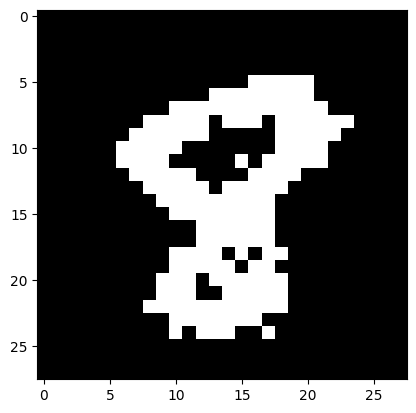

Training Sample: 


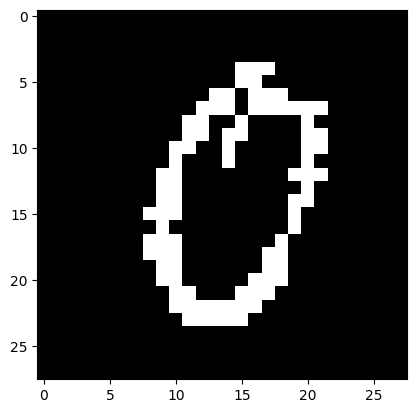

Generated Sample: 


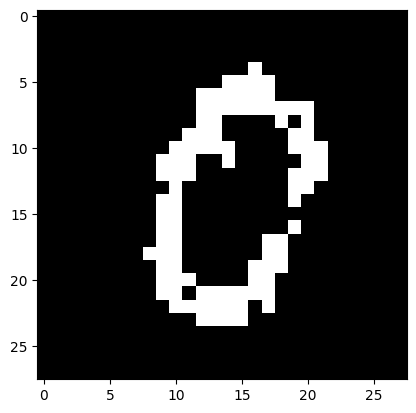

Training Sample: 


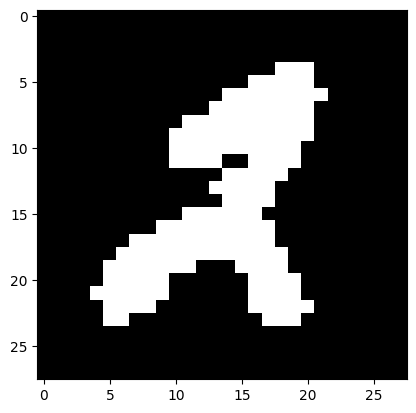

Generated Sample: 


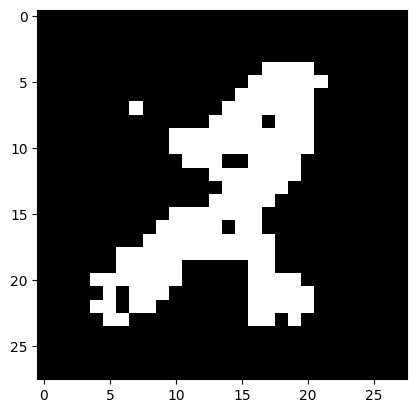

In [44]:
for i in range(10,15):
  # displaying the first digit in the batch
  print("Training Sample: ")
  sample_real = v[i].squeeze().cpu().numpy()
  sample_real = sample_real.reshape(28, 28)
  plt.imshow(sample_real, cmap='gray')
  plt.show()

  print ("Generated Sample: ")
  sample_real = v1[i].squeeze().cpu().numpy()
  sample_real = sample_real.reshape(28, 28)
  plt.imshow(sample_real, cmap='gray')
  plt.show()
